## Import Functions

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras.models import model_from_json
from keras.models import load_model
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)

%matplotlib inline

Using TensorFlow backend.


## Plotting The Close Prices 

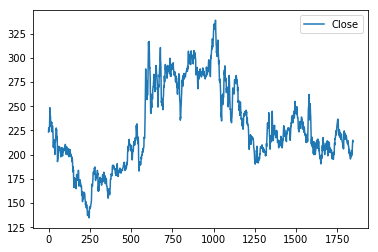

<Figure size 432x288 with 0 Axes>

In [4]:
data_csv = pd.read_csv("/Users/maharshichattopadhyay/Documents/Study/Major_Project/DataSet/Final_Dataset/Final_Data_MCB.csv")
data_csv[['Close']].plot()
plt.show()
plt.clf()

## Calculating the length of data to use

In [5]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(data_csv)-1))

# 80% of data will be of training
train_end = int(data_to_use*0.8)

total_data = len(data_csv)
print("total_data:", total_data)

total_data: 1846


## Re-Arranging the data

In [12]:
start = total_data - data_to_use

# Currently doing prediction only for 1 step ahead
steps_to_predict = 1

#close, compund, neg, neu, pos, open, high, low, volume
# Order -> 8,1,2,3,4,5,6,7,9
close = data_csv.iloc[start:total_data,8] #close
compound = data_csv.iloc[start:total_data,1] #compund
neg = data_csv.iloc[start:total_data,2] #neg
neu = data_csv.iloc[start:total_data,3] #neu
pos = data_csv.iloc[start:total_data,4] #pos
open = data_csv.iloc[start:total_data,5] #open
high = data_csv.iloc[start:total_data,6] #high
low = data_csv.iloc[start:total_data,7] #low
volume = data_csv.iloc[start:total_data,9] #volume

In [13]:
#shift next day close and next day compund
shifted_close = close.shift(-1) #shifted close
shifted_compound = compound.shift(-1) #shifted compund

#taking only: close, next_close, compund, next_compund, volume, open, high, low
data = pd.concat([close, shifted_close, compound, shifted_compound, volume, open, high, low], axis=1)
data.columns = ['close', 'shifted_close', 'compound', 'shifted_compound','volume', 'open', 'high', 'low']

data = data.dropna()
     
print(data[:10])

     close  shifted_close  compound  shifted_compound   volume    open  \
1   227.97         226.27   -0.6996           -0.9442  1601540  223.32   
2   226.27         226.16   -0.9442           -0.7906  2181684  227.00   
3   226.16         225.99   -0.7906           -0.5859  1034935  227.00   
4   225.99         224.44   -0.5859           -0.9723  1247251  227.50   
5   224.44         228.58   -0.9723           -0.9578   571792  227.50   
6   228.58         238.68   -0.9578           -0.3818  1501995  225.25   
7   238.68         248.46   -0.3818           -0.7184  4938671  229.00   
8   248.46         243.35   -0.7184           -0.8720  3835913  240.00   
9   243.35         244.64   -0.8720           -0.5994  1974180  249.25   
10  244.64         239.77   -0.5994           -0.7506  1800665  245.35   

      high     low  
1   229.50  223.32  
2   232.00  225.60  
3   227.65  224.20  
4   227.99  223.80  
5   228.00  223.50  
6   229.29  223.61  
7   239.85  229.00  
8   250.48  238.5

## Separating data into x and y

In [16]:
#Approach: Training the machine using compund, close price, and next_compund to predict next_close price.
y = data['shifted_close'] #next_close
# close, compund, next_compund, volume, open, high, low   
cols = ['close', 'compound', 'shifted_compound','volume', 'open', 'high', 'low']
x = data[cols]

## Preprocessing

In [17]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

## Data-Splitting

In [23]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

X_train = X_train.reshape (X_train. shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))
print(X_train.shape)
print(X_test.shape)

(1476, 7, 1)
(367, 7, 1)


## LSTM-RNN Model

In [25]:
batch_size = 32
nb_epoch = 100
neurons = 25
dropout = 0.1
seed = 2016
np.random.seed(seed)
model = Sequential ()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', inner_activation='hard_sigmoid', input_shape=(len(cols), 1)))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True,  activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))
model.add(Dense(activity_regularizer=regularizers.l1(0.00001), output_dim=1, activation='linear'))
model.add(Activation('tanh'))
model.compile(loss='mean_squared_error' , optimizer='RMSprop')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(25, return_sequences=True, activation="tanh", input_shape=(7, 1), recurrent_activation="hard_sigmoid")`
  


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activity_regularizer=<keras.reg..., activation="linear", units=1)`
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1180 samples, validate on 296 samples
Epoch 1/100
1180/1180 [==============================] - 3s 3ms/step - loss: 0.1390 - val_loss: 0.0568
Epoch 2/100
1180/1180 [==============================] - 1s 643us/step - loss: 0.0523 - val_loss: 0.0659
Epoch 3/100
1180/1180 [==============================] - 1s 641us/step - loss: 0.0523 - val_loss: 0.0560
Epoch 4/100
1180/1180 [==============================] - 1s 662us/step - loss: 0.0501 - val_loss: 0.0601
Epoch 5/100
1180/1180 [==============================] - 1s 748us/step - loss: 0.0501 - val_loss: 0.0628
Epoch 6/100
1180/1180 [==============================] - 1s 1ms/step - loss: 0.0468 - val_loss: 0.0616
Epoch 7/100
1180/1180 [==============================] - 1s 1ms/step - loss: 0.0458 - val_loss: 0.0737
Epoch 8/100
1180/1180 [==============================] - 1s 831us/step - loss: 0.0435 - val_loss: 0.0504
Epoch 9/100
1180/1180 [==============================] - 1s 976us/step - loss: 0.0408 - val_loss: 0.0516
Epoch 10/100
1

1180/1180 [==============================] - 1s 726us/step - loss: 0.0047 - val_loss: 0.0021
Epoch 79/100
1180/1180 [==============================] - 1s 714us/step - loss: 0.0045 - val_loss: 0.0021
Epoch 80/100
1180/1180 [==============================] - 1s 713us/step - loss: 0.0045 - val_loss: 0.0022
Epoch 81/100
1180/1180 [==============================] - 1s 676us/step - loss: 0.0044 - val_loss: 0.0023
Epoch 82/100
1180/1180 [==============================] - 1s 715us/step - loss: 0.0041 - val_loss: 0.0022
Epoch 83/100
1180/1180 [==============================] - 1s 671us/step - loss: 0.0042 - val_loss: 0.0021
Epoch 84/100
1180/1180 [==============================] - 1s 695us/step - loss: 0.0046 - val_loss: 0.0028
Epoch 85/100
1180/1180 [==============================] - 1s 740us/step - loss: 0.0047 - val_loss: 0.0021
Epoch 86/100
1180/1180 [==============================] - 1s 606us/step - loss: 0.0045 - val_loss: 0.0022
Epoch 87/100
1180/1180 [==============================] - 1

## Predictions

In [26]:
pred = model.predict(X_test) 
pred = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))
prediction_data = pred[-1]   
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

## Plot

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


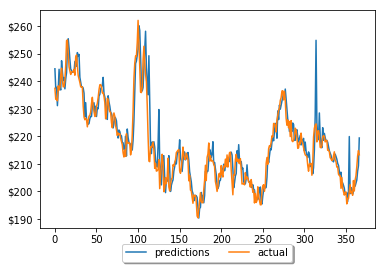

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(pred, label="predictions")
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len( y_test), 1)))
plt.plot([row[0] for row in y_test], label="actual")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
plt.show()
plt.clf()